In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from adjustText import adjust_text
from scipy.sparse import coo_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader

random.seed(42)
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [2]:
def read_mtx(path, index):
    contact_mat = pd.read_csv(path, sep="\t", header=0)
    contact_mat = contact_mat[(contact_mat["chrom1"] != "chrY") & (contact_mat["chrom2"] != "chrY")]
    contact_mat = pd.concat([contact_mat["chrom1"] + "_" + contact_mat["start1"].astype(str),
                             contact_mat["chrom2"] + "_" + contact_mat["start2"].astype(str), contact_mat["count"]],
                            axis=1)
    contact_mat.columns = ["loc1", "loc2", "count"]
    contact_mat = pd.merge(contact_mat, index, left_on="loc1", right_on="loc", how="left").drop(["loc", "loc1"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index1"})
    contact_mat = pd.merge(contact_mat, index, left_on="loc2", right_on="loc", how="left").drop(["loc", "loc2"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index2"})
    contact_mat = coo_matrix((contact_mat['count'], (contact_mat['index1'], contact_mat['index2'])),
                             shape=(index.shape[0], index.shape[0]))
    contact_mat = contact_mat.toarray()

    return contact_mat

### Prepare data

In [ ]:
orig_index = pd.read_csv("data/LC675_TTTGGTTGTTGGCGAA/1000000.CNV.bedGraph", sep="\t", header=None).iloc[:, 0:3]

orig_index.columns = ["chrom", "start", "end"]
orig_index = orig_index[orig_index["chrom"] != "chrY"]
orig_index = orig_index["chrom"] + "_" + orig_index["start"].astype(str)
orig_index = pd.concat([orig_index, pd.DataFrame(np.arange(orig_index.shape[0]))], axis=1)
orig_index.columns = ["loc", "index"]

orig_index.to_csv("index.csv", index=False)

In [3]:
def prep_data(sample, coord, index, is_pos, win0):
    matrices_f2 = []

    directories = sorted([d for d in os.listdir("data/" + sample) if os.path.isdir(os.path.join("data/" + sample, d))])
    for directory in directories:

        if not os.path.exists("data/" + sample + "/" + directory + "/1000000.CNV.bedGraph"):
            continue

        try:
            mtx = read_mtx("data/" + sample + "/" + directory + "/matrix.mtx", index)
        except:
            continue

        mtx_f2 = mtx[(coord - int((win0 + 1) / 2) + 1):(coord + int((win0 + 1) / 2)), :]

        stacked_mtx_f2 = torch.from_numpy(mtx_f2).to_sparse_coo()

        matrices_f2.append(stacked_mtx_f2)

    input = torch.stack(matrices_f2, dim=0)

    if is_pos:
        label = torch.from_numpy(np.ones(input.shape[0])).int()
    else:
        label = torch.from_numpy(np.zeros(input.shape[0])).int()

    dirs = [sample + "/" + item for item in directories]

    return input, label, dirs

In [4]:
chr_index = pd.read_csv("index.csv", header=0)
pos_coord = np.where(chr_index["loc"] == "chr7_55000000")[0][0]
window_0 = 5

pos_f2, pos_label, pos_dirs = prep_data("LC499", pos_coord, chr_index, True, window_0)
neg_f2, neg_label, neg_dirs = prep_data("LC500", pos_coord, chr_index, False, window_0)

input_all = torch.cat((pos_f2, neg_f2), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
dirs = pos_dirs + neg_dirs

In [10]:
torch.save(input_all, "input_all.npy")
torch.save(label, "label.npy")
torch.save(dirs, "dirs.npy")

### Train model

In [3]:
input_all = torch.load("input_all.npy").to_dense()
label = torch.load("label.npy")
dirs = torch.load("dirs.npy")

In [4]:
chr_index = pd.read_csv("index.csv", header=0)
pos_coord = np.where(chr_index["loc"] == "chr7_55000000")[0][0]

window_0 = 5
window_1 = 45

In [5]:
val_split = 0.1

len_indices = len(input_all)
all_indices = list(range(len_indices))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indices))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_train = torch.index_select(input_all, 0, train_indices)
label_train = torch.index_select(label, 0, train_indices)
dirs_train = [dirs[i] for i in train_indices]

input_val = torch.index_select(input_all, 0, val_indices)
label_val = torch.index_select(label, 0, val_indices)
dirs_val = [dirs[i] for i in val_indices]

In [6]:
class TriDataset(Dataset):
    def __init__(self, input, label, dirs):
        self.input = input
        self.label = label
        self.dirs = dirs

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_s = self.input[index]
        label_s = self.label[index]
        dir_s = self.dirs[index]

        return input_s, label_s, dir_s

In [7]:
batch_size = 32
train_dataloader = DataLoader(TriDataset(input_train, label_train, dirs_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TriDataset(input_val, label_val, dirs_val), batch_size=batch_size, shuffle=True)

In [8]:
def zi_pois_noise(shape, lambda_, p_zero):
    uniform_noise = torch.rand(shape)

    zero_mask = uniform_noise < p_zero

    poisson_noise = torch.poisson(lambda_ * torch.ones(shape))

    noise = poisson_noise * ~zero_mask

    return noise

In [290]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_f1_l1 = nn.Conv2d(1, 8, kernel_size=(window_0, 5), stride=(1, 1), padding=(0, 2))
        self.conv_f1_l2 = nn.Conv2d(8, 16, kernel_size=(1, 5), stride=(1, 2), padding=(0, 0))
        self.conv_f2_l1 = nn.Conv2d(1, 8, kernel_size=(window_0, 45), stride=(1, 11), padding=(0, 2))
        self.conv_f2_l2 = nn.Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4), padding=(0, 0))

        self.bn_f1_l1 = nn.BatchNorm2d(8)
        self.bn_f1_l2 = nn.BatchNorm2d(16)
        self.bn_f2_l1 = nn.BatchNorm2d(8)
        self.bn_f2_l2 = nn.BatchNorm2d(16)
        self.bn_fc_f1 = nn.BatchNorm1d(64)
        self.bn_fc_f2 = nn.BatchNorm1d(64)
        self.bn_fc_l1 = nn.BatchNorm1d(64)

        #self.pool_f1_l1 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)
        self.pool_f2_l1 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)

        self.fc_f1_l1 = nn.Linear(21 * 16, 64)
        self.fc_f2_l1 = nn.Linear(24 * 16, 64)
        self.fc_l1 = nn.Linear(64 + 64 + window_0, 64)
        self.fc_l2 = nn.Linear(64, 1)

        self.dropout_f1 = nn.Dropout(0.5)
        self.dropout_f2 = nn.Dropout(0.5)
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x2, coord):
        if self.training:
            noise = zi_pois_noise(x2.shape, 1, 0.999) # test this
            x2 = x2 + noise.float().to("mps")
            
        start_indices = coord - int((window_1 + 1) / 2) + 1
        end_indices = coord + int((window_1 + 1) / 2)
            
        ###### Construction in progress ######
        
        d4_slices = []

        for i in range(x2.size(0)):
            d4_slices.append(x2[i, ..., start_indices[i]:end_indices[i]])

        x1 = torch.stack(d4_slices, dim=0)
                
        ###### Construction in progress ######

        x1 = torch.log2(x1 + 1)
        x2 = (x2 > 0).float()

        x2_s = F.normalize(torch.squeeze(torch.sum(x2, dim=-1), dim=1), dim=-1, p=1)

        x1 = self.bn_f1_l1(F.relu(self.conv_f1_l1(x1)))
        x1 = F.relu(self.bn_f1_l2(self.conv_f1_l2(x1)))

        x2 = self.pool_f2_l1(F.relu(self.bn_f2_l1(self.conv_f2_l1(x2))))
        x2 = F.relu(self.bn_f2_l2(self.conv_f2_l2(x2)))

        x1 = x1.view(-1, 21 * 16)
        x2 = x2.view(-1, 24 * 16)

        x1 = self.dropout_f1(F.relu(self.bn_fc_f1(self.fc_f1_l1(x1))))
        x2 = self.dropout_f2(F.relu(self.bn_fc_f2(self.fc_f2_l1(x2))))

        x = torch.cat((x1, x2, x2_s), dim=1)

        x = self.dropout_fc(F.gelu(self.bn_fc_l1(self.fc_l1(x))))

        x = self.fc_l2(x)

        return x.squeeze(-1)

In [291]:
model = CNN().to("mps")

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([0.01])).to("mps")

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

train_losses_epoch = []
val_losses_epoch = []
accuracies_epoch = []
epochs = []

val_labels = []
val_predictions = []
val_directories = []

num_epochs = 50
prob_threshold = 0.5

In [292]:
for epoch in range(num_epochs):
    losses = []
    sizes = []

    model.train()
    for x2, y0, _ in train_dataloader:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")
        
        optimizer.zero_grad()
        yh = model(x2, np.repeat(pos_coord, x2.shape[0]))
        loss = criterion(yh, y0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        sizes.append(len(y0))

    train_loss = np.average(losses, weights=sizes)

    losses = []
    sizes = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for x2, y0, dir in val_dataloader:

            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, np.repeat(pos_coord, x2.shape[0]))
            loss = criterion(yh, y0)

            yp = (torch.sigmoid(yh) > prob_threshold).int()

            accu = torch.sum((yp == y0).float()) / len(y0)

            losses.append(loss.item())
            accuracies.append(accu.item())
            sizes.append(len(y0))

            if epoch + 1 == num_epochs:
                val_labels = val_labels + y0.int().to("cpu").numpy().tolist()
                val_predictions = val_predictions + yp.to("cpu").numpy().tolist()
                val_directories = val_directories + list(dir)

        val_loss = np.average(losses, weights=sizes)
        val_accu = np.average(accuracies, weights=sizes)

    train_losses_epoch.append(train_loss)
    val_losses_epoch.append(val_loss)
    accuracies_epoch.append(val_accu)
    epochs.append(epoch + 1)

    print(
        f'epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_accu: {val_accu * 100:.2f}%')

epoch 1/50, train_loss: 0.2860, val_loss: 0.1797, val_accu: 88.69%
epoch 2/50, train_loss: 0.1607, val_loss: 0.1203, val_accu: 90.63%
epoch 3/50, train_loss: 0.1121, val_loss: 0.0817, val_accu: 89.26%
epoch 4/50, train_loss: 0.0812, val_loss: 0.0510, val_accu: 88.91%
epoch 5/50, train_loss: 0.0596, val_loss: 0.0423, val_accu: 89.26%
epoch 6/50, train_loss: 0.0444, val_loss: 0.0336, val_accu: 89.60%
epoch 7/50, train_loss: 0.0346, val_loss: 0.0238, val_accu: 89.03%
epoch 8/50, train_loss: 0.0286, val_loss: 0.0214, val_accu: 89.60%
epoch 9/50, train_loss: 0.0239, val_loss: 0.0195, val_accu: 89.60%
epoch 10/50, train_loss: 0.0197, val_loss: 0.0140, val_accu: 89.49%
epoch 11/50, train_loss: 0.0166, val_loss: 0.0126, val_accu: 89.60%
epoch 12/50, train_loss: 0.0143, val_loss: 0.0105, val_accu: 88.80%
epoch 13/50, train_loss: 0.0125, val_loss: 0.0094, val_accu: 88.69%
epoch 14/50, train_loss: 0.0117, val_loss: 0.0089, val_accu: 89.14%
epoch 15/50, train_loss: 0.0105, val_loss: 0.0087, val_ac

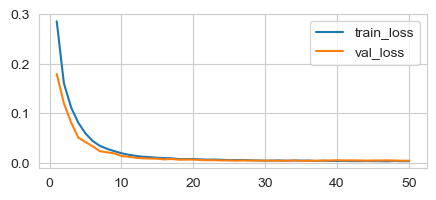

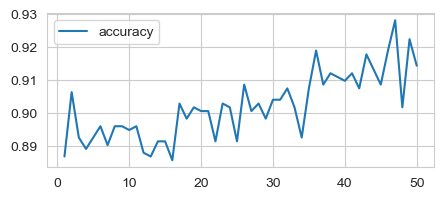

In [293]:
plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(epochs, accuracies_epoch, label='accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [294]:
pred_summary = pd.DataFrame({"label": val_labels, "prediction": val_predictions, "directory": val_directories})
pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]
pred_summary

,label,prediction,directory,correct
0,1,0,LC499/LC499_AATGCCAGTTCTTTCA,False
1,0,0,LC500/LC500_GACCTTCAGGCAATTA,True
2,0,0,LC500/LC500_AATGTCGAGCGAGAAA,True
3,0,0,LC500/LC500_GACCAATAGGTCCTCG,True
4,0,0,LC499/LC499_TTTGTGTTCGGTTCCT,True
...,...,...,...,...
870,0,0,LC500/LC500_TTGCAGACACCATTCC,True
871,1,0,LC499/LC499_AACTGTGTCCTTGACC,False
872,1,1,LC499/LC499_TGGCCTTTCTAGCAAC,True
873,0,0,LC500/LC500_CGTTCCATCCGTACGG,True


In [295]:
conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
precision = precision_score(pred_summary["label"], pred_summary["prediction"])
recall = recall_score(pred_summary["label"], pred_summary["prediction"])
f1 = f1_score(pred_summary["label"], pred_summary["prediction"])
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

pd.DataFrame(conf_matrix, index=["TN", "TP"], columns=["PN", "PP"])

Accuracy: 0.91
Precision: 1.00
Sensitivity: 0.75
Specificity: 1.00
F1 Score: 0.86


,PN,PP
TN,572,0
TP,75,228


### Test model

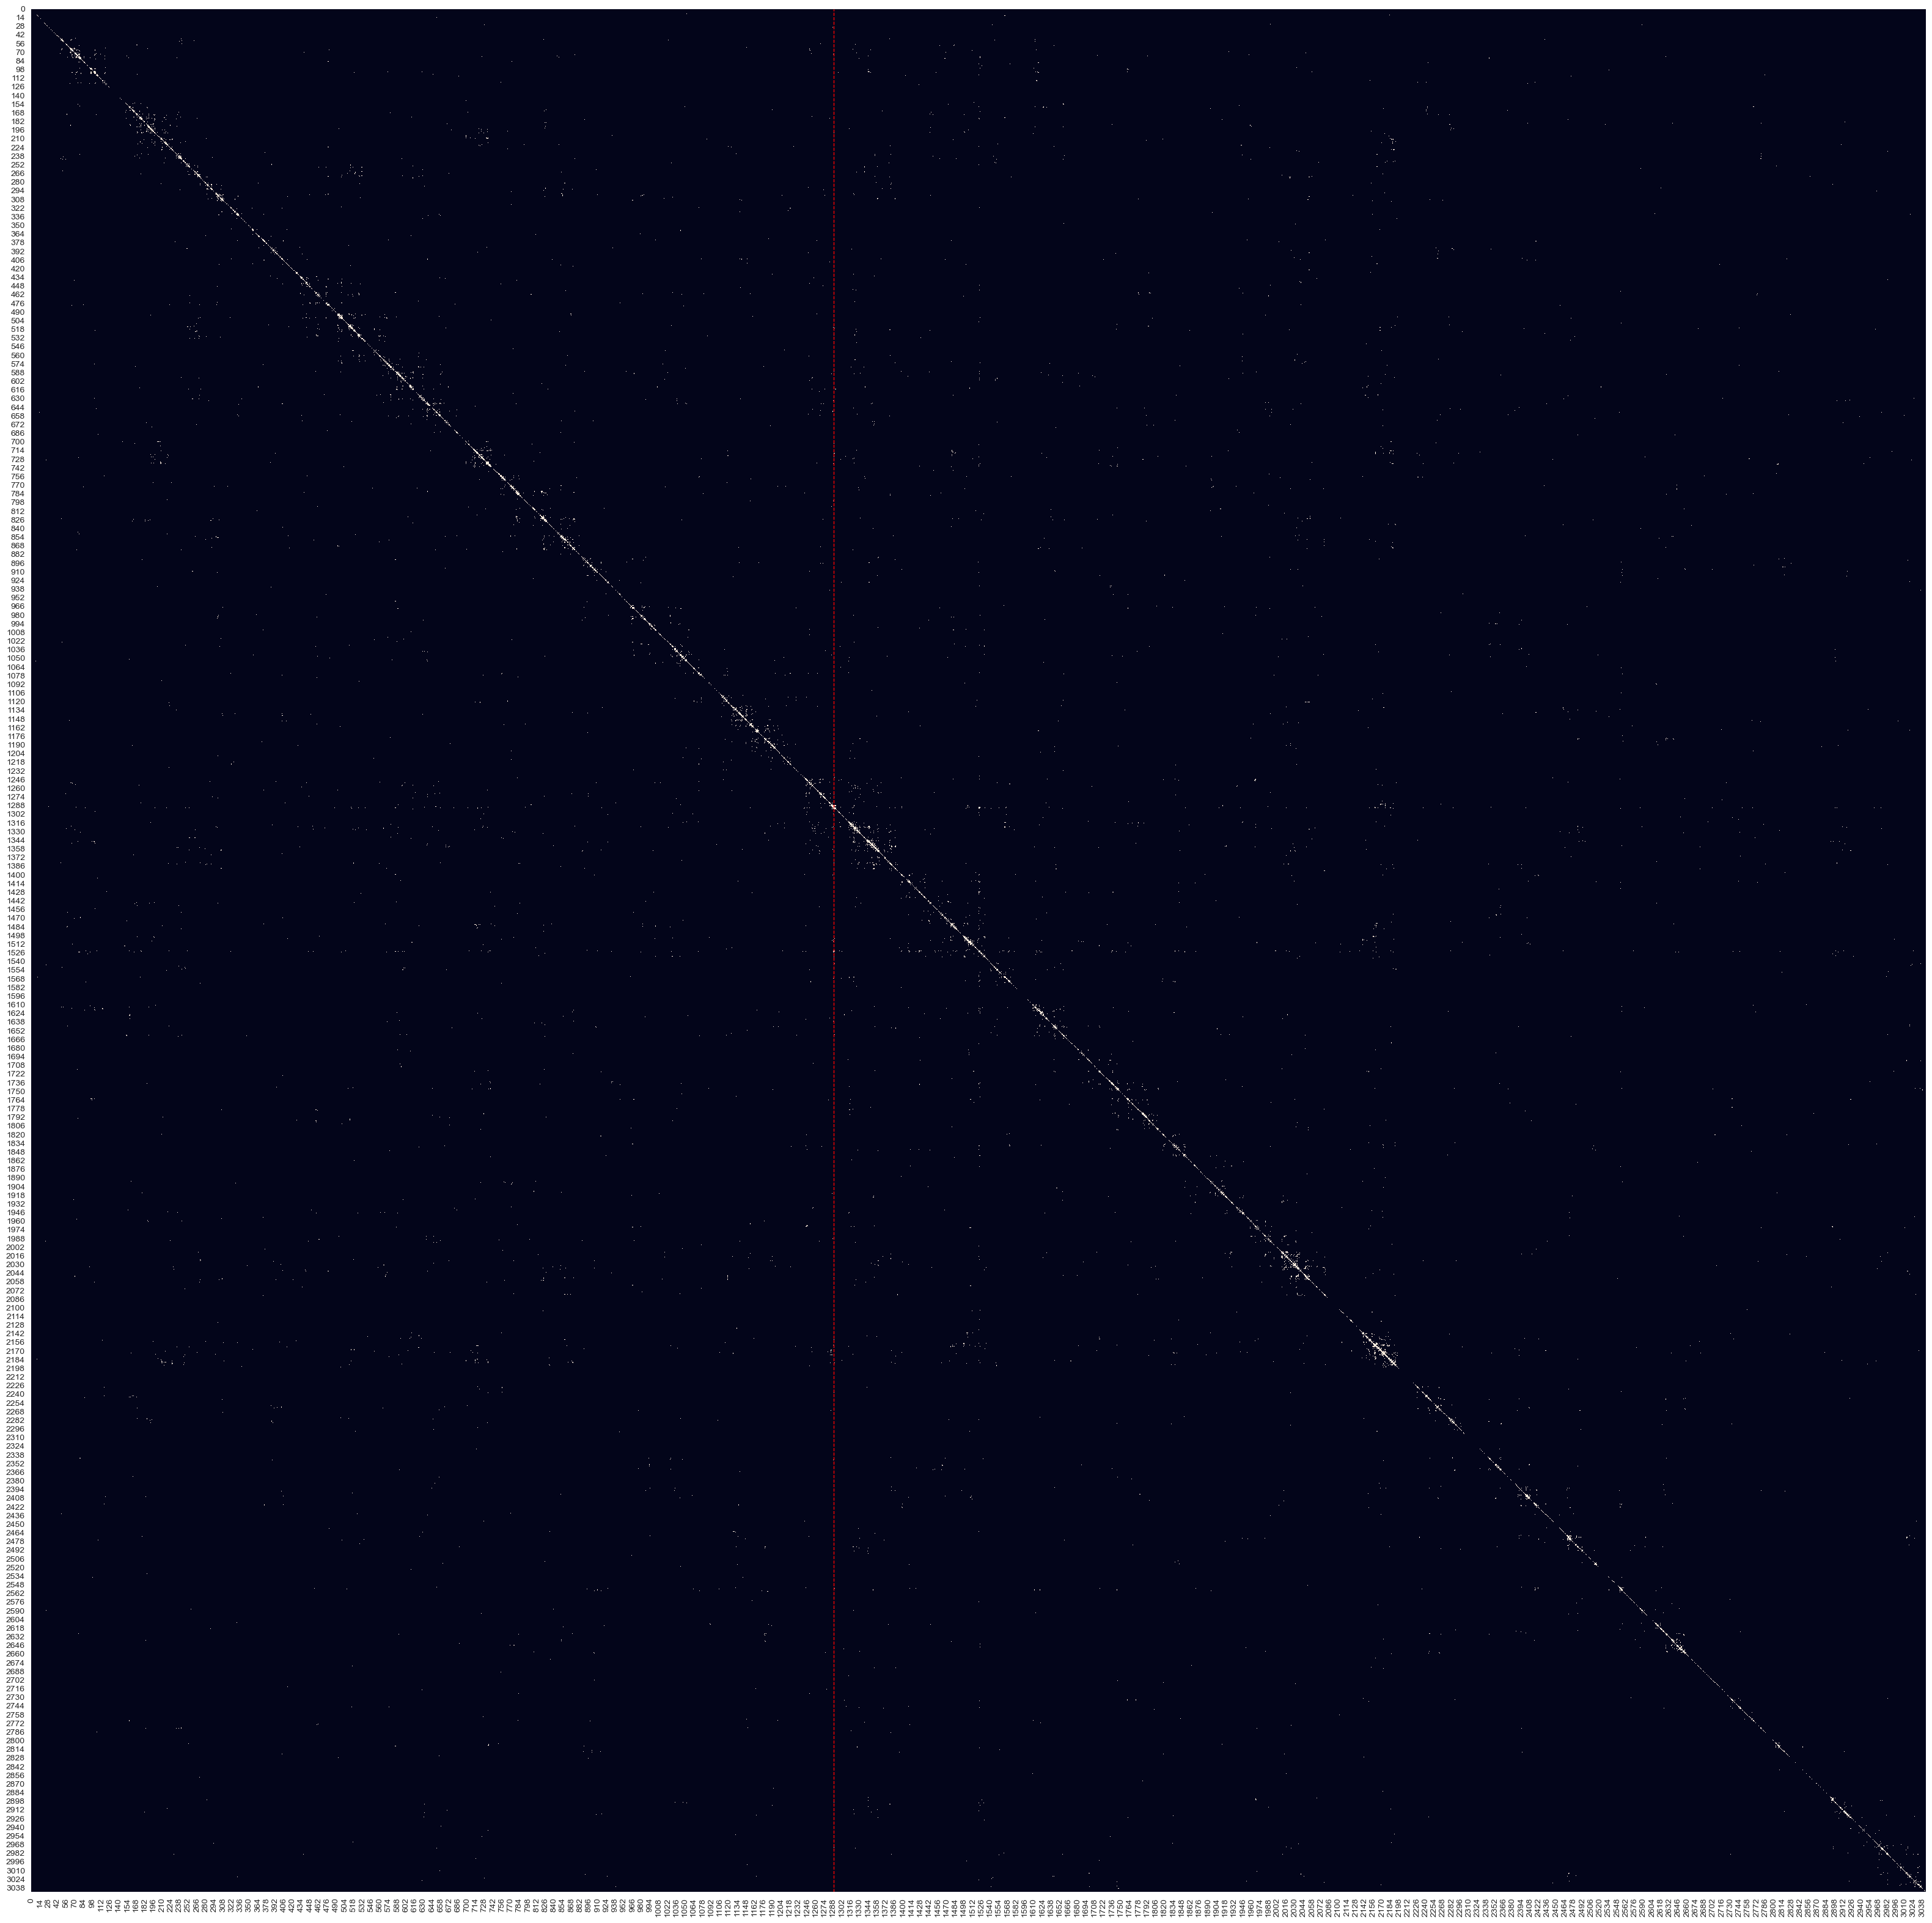

In [296]:
matrix_test = read_mtx("data/LC499/LC499_TTATGTCAGAGGAACA/matrix.mtx", chr_index)
#LC499/LC499_TTATGTCAGAGGAACA
#LC499/LC499_AACGGGAGTCCCGAGT
#LC675/LC675_AGCGTGCAGAGAGTAG

plt.figure(figsize=(40, 40))
plot = sns.heatmap(matrix_test > 0, cbar=False)

coord = np.where(chr_index["loc"] == "chr7_55000000")[0][0]
plot.axvline(x=coord, color='red', linestyle='--', linewidth=1)
plt.show()

In [297]:
def slide(matrix, window_0, window_1):
    half_window_0 = int((window_0 - 1) / 2)
    half_window_1 = int((window_1 - 1) / 2)
    
    centers = []
    tensors = []

    for i in range(matrix.shape[0] - window_1 + 1):
        center = i + half_window_1
        lower = center - half_window_0
        upper = center + half_window_0 + 1
        
        tensors.append(matrix[lower:upper, :])
        centers.append(center)
        
    test_tensor = torch.stack(tensors, dim=0)
    centers = np.array(centers)

    return test_tensor, centers

In [298]:
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.sigmoid(model(test_tensor, centers)).to("cpu")

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index", axis=1)

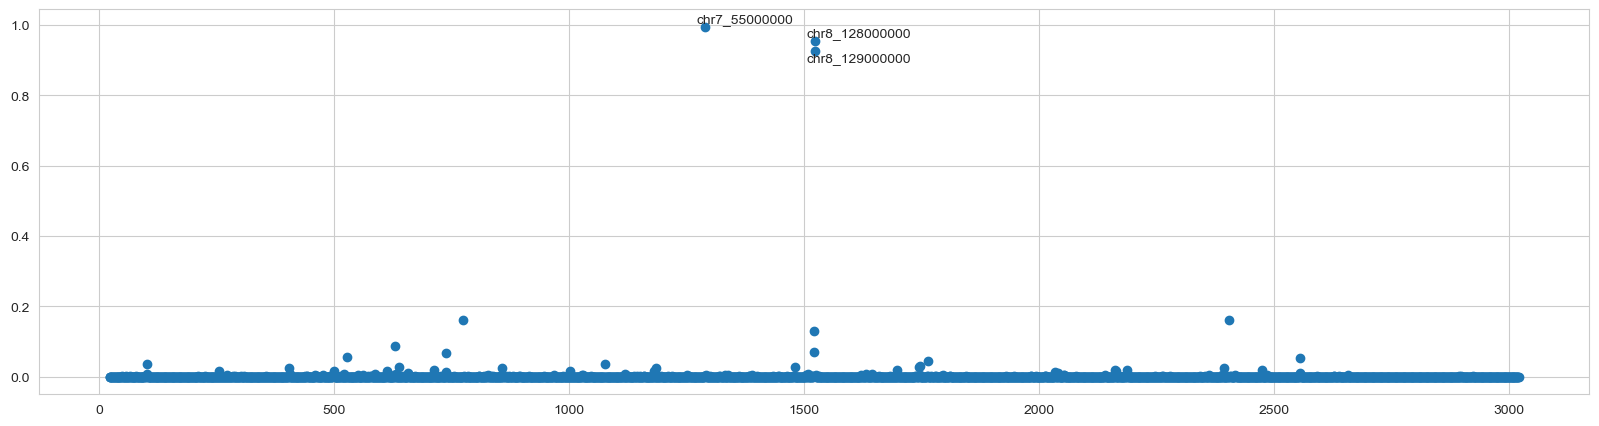

In [299]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-3:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.show()